In [ ]:
# Tahap 1: Import library

from rembg import remove
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import io
from sklearn.cluster import KMeans

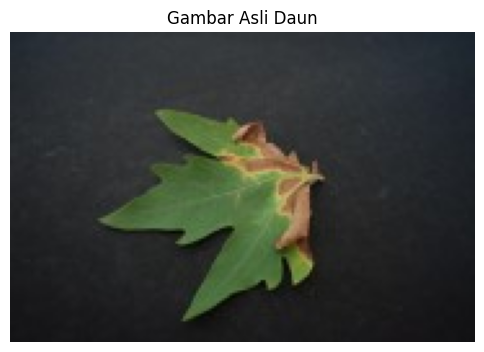

In [ ]:
# # Tahap 2: Upload dan Baca Gambar Daun
"""
print("Silakan upload gambar daun (format JPG atau PNG):")
uploaded = files.upload()
for filename in uploaded.keys():
    image_path = filename
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6,6))
plt.imshow(image_rgb)
plt.title("Gambar Asli Daun")
plt.axis("off")
plt.show()
"""
image_path = "img\\0022_0003.JPG"
image = cv2.imread(image_path)
if image is None:
    print("Gambar tidak ditemukan. Periksa kembali path-nya.")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,6))
    plt.imshow(image_rgb)
    plt.title("Gambar Asli Daun")
    plt.axis("off")
    plt.show()


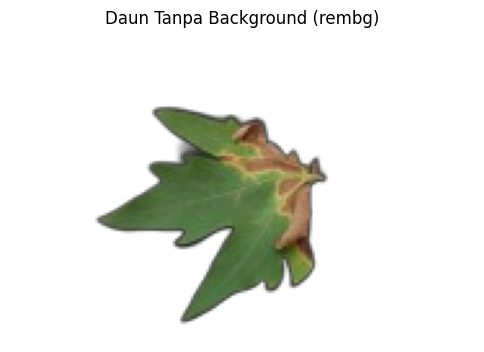

Tipe data gambar: <class 'PIL.Image.Image'>
Mode warna: RGBA
Ukuran gambar: (180, 120)


In [ ]:
# Tahap 2.5: Menghapus Background dengan rembg

from rembg import remove
from PIL import Image
import io

with open(image_path, "rb") as f:
    input_image = f.read()

output_image = remove(input_image)

result = Image.open(io.BytesIO(output_image)).convert("RGBA")

plt.figure(figsize=(6,6))
plt.imshow(result)
plt.title("Daun Tanpa Background (rembg)")
plt.axis("off")
plt.show()

print("Tipe data gambar:", type(result))
print("Mode warna:", result.mode)
print("Ukuran gambar:", result.size)



In [ ]:
# Tahap 3: Mengonversi Gambar ke Data untuk K-Means (Hanya Objek Daun)

image_rgba = np.array(result)

rgb = image_rgba[:, :, :3]
alpha = image_rgba[:, :, 3]

mask_leaf = alpha > 128

pixels_leaf = rgb[mask_leaf]

pixels_leaf = np.float32(pixels_leaf)

print("Jumlah total piksel daun:", pixels_leaf.shape[0])
print("Contoh data piksel daun (R,G,B):")
print(pixels_leaf[:5])


Jumlah total piksel daun: 3578
Contoh data piksel daun (R,G,B):
[[33. 38. 29.]
 [38. 44. 33.]
 [42. 48. 35.]
 [40. 48. 34.]
 [35. 43. 28.]]


In [ ]:
# Tahap 4: Segmentasi Daun Menggunakan K-Means (K = 4)


K = 4

kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels = kmeans.fit_predict(pixels_leaf)

centers = np.uint8(kmeans.cluster_centers_)

print("Warna pusat (centroid) tiap cluster:")
print(centers)


Warna pusat (centroid) tiap cluster:
[[ 76 102  56]
 [161 138  90]
 [ 40  42  23]
 [ 97 121  69]]


In [ ]:
# Tahap 4.5: Klasifikasi Warna Tiap Cluster Daun

def classify_leaf_color(rgb_color):
    r, g, b = rgb_color

    if g > r and g > b:
        return "Daun Sehat (Hijau)"
    elif r > 150 and g > 150 and b < 100:
        return "Daun Sedikit Sakit (Kuning)"
    elif r > g and r > b and r > 120:
        return "Daun Sakit (Coklat Kekuningan)"
    elif r < 90 and g < 90 and b < 90:
        return "Daun Rusak Parah (Gelap)"
    else:
        return "Lainnya"

labels_keterangan = [classify_leaf_color(c) for c in centers]

for i, (color, desc) in enumerate(zip(centers, labels_keterangan)):
    print(f"Cluster {i+1}: {color} → {desc}")


Cluster 1: [ 76 102  56] → Daun Sehat (Hijau)
Cluster 2: [161 138  90] → Daun Sakit (Coklat Kekuningan)
Cluster 3: [40 42 23] → Daun Sehat (Hijau)
Cluster 4: [ 97 121  69] → Daun Sehat (Hijau)


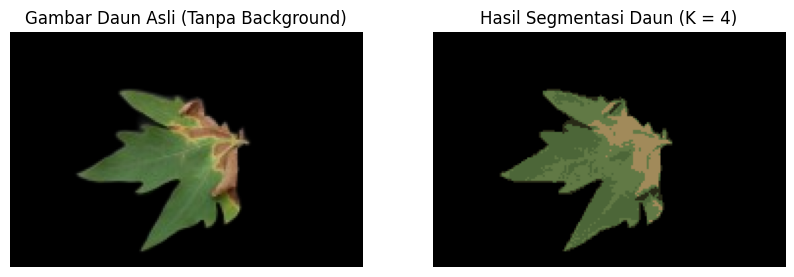

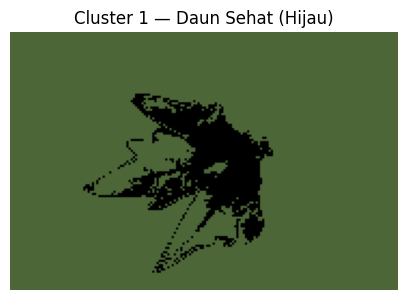

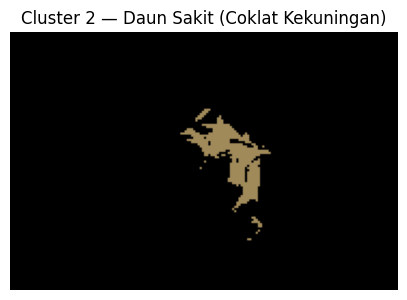

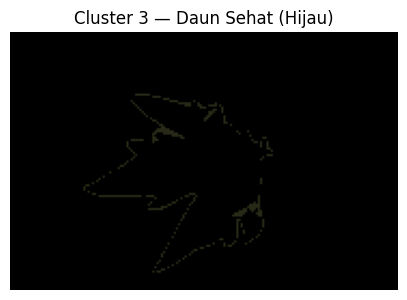

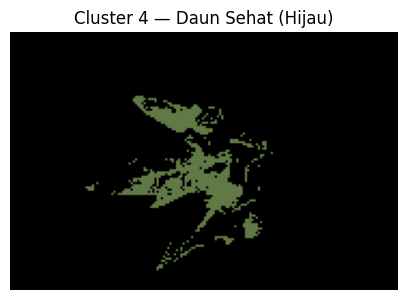

In [ ]:
# Tahap 5: Visualisasi Hasil Segmentasi Daun (4 Cluster)

segmented_image = np.zeros_like(rgb)

segmented_image[mask_leaf] = centers[labels]

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(rgb)
plt.title("Gambar Daun Asli (Tanpa Background)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(segmented_image)
plt.title("Hasil Segmentasi Daun (K = 4)")
plt.axis("off")

plt.show()

height, width, _ = rgb.shape

label_image = np.zeros((height, width), dtype=np.uint8)
label_image[mask_leaf] = labels

for i, (color, desc) in enumerate(zip(centers, labels_keterangan)):
    cluster_mask = np.zeros((height, width, 3), dtype=np.uint8)

    cluster_mask[label_image == i] = color

    plt.figure(figsize=(5,5))
    plt.imshow(cluster_mask)
    plt.title(f"Cluster {i+1} — {desc}")
    plt.axis("off")
    plt.show()


In [ ]:
# Tahap 6: Simpan Hasil Segmentasi ke File

import os
from PIL import Image

output_dir = "hasil_segmentasi"
os.makedirs(output_dir, exist_ok=True)

segmented_pil = Image.fromarray(segmented_image)
segmented_pil.save(os.path.join(output_dir, "hasil_segmentasi_daun.png"))
print("Hasil segmentasi gabungan disimpan sebagai: hasil_segmentasi_daun.png")

for i, (color, desc) in enumerate(zip(centers, labels_keterangan)):
    cluster_mask = np.zeros((height, width, 3), dtype=np.uint8)
    cluster_mask[label_image == i] = color

    cluster_pil = Image.fromarray(cluster_mask)
    file_name = f"cluster_{i+1}_{desc.replace(' ', '_')}.png"
    cluster_pil.save(os.path.join(output_dir, file_name))

print("Semua cluster berhasil disimpan di folder 'hasil_segmentasi/'")


Hasil segmentasi gabungan disimpan sebagai: hasil_segmentasi_daun.png
Semua cluster berhasil disimpan di folder 'hasil_segmentasi/'
